# `FakeNewsNET` dataset - Colab

In [32]:
import numpy as np
import pandas as pd
# from google.cloud import storage

import matplotlib.pyplot as plt

### Loading `CSV` file from GCP Buket

In [33]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/ISOT_True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/ISOT_Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

In [34]:
true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [35]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Remove `Reuters` initial part from `True.csv`

In [36]:
import re

def remove_reuters(text):
    return re.sub(r'^.*? - ', '', text)

true['text'] = true['text'].apply(remove_reuters)

true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"


## Duplicates

In [37]:
def count_duplicate(df):
    return df.duplicated().sum()

In [38]:
print('-'*80)
print(f"true duplicates: {count_duplicate(true)}")
print(f"fake duplicates: {count_duplicate(fake)}")
print('-'*80)

--------------------------------------------------------------------------------
true duplicates: 206
fake duplicates: 3
--------------------------------------------------------------------------------


In [39]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [40]:
true['category'] = 0
fake['category'] = 1

data = pd.concat([true, fake]).reset_index()

print('-'*80)
print(f"data shape: {data.shape}")
print('-'*80)
print(f"ratio #true: {len(data[data['category']==0])/len(data)*100:.2f}%")
print(f"ratio #fake: {len(data[data['category']==1])/len(data)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data shape: (44689, 6)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


## Missing values

In [41]:
def get_missing(df):
    missing_values = df.isnull().sum().sort_values(ascending = False)
    ratio = missing_values/len(data)*100
    return pd.DataFrame({'missing_values': missing_values, 'ratio': round(ratio)}).head(10)

In [42]:
get_missing(data)

,missing_values,ratio
category,0,0.0
date,0,0.0
subject,0,0.0
text,0,0.0
title,0,0.0
index,0,0.0


### Preprocessing

In [43]:
hparams = {
    "clean_text": True,
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 250
}

In [17]:
# TEST KWARGS
# def test(**kwargs):
#     return hparams['max_sequence_length'], hparams['embedding_dim']

# test(**hparams)

In [44]:
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    """
    Provided by Le Wagon - Machine Learning - NLP
    Preprocessing articles - punctuation / lowercased / tokenize (not number) / stop_words / lemmatize
    """
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

if hparams['clean_text']:
    X_text = data['text'].apply(clean).copy()
    X_title = data['title'].apply(clean).copy()
    y = data['category'].copy()
else:
    X_text = data['text'].copy()
    X_title = data['title'].copy()
    y = data['category'].copy()

print('-'*80)
print(f"X_text shape: {X_text.shape}")
print(f"X_title shape: {X_title.shape}")
print(f"y shape: {y.shape}")
print('-'*80)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
--------------------------------------------------------------------------------
X_text shape: (44689,)
X_title shape: (44689,)
y shape: (44689,)
--------------------------------------------------------------------------------


In [62]:
X_text.sample(10)

30773    [daily, caller, revelation, monday, former, tr...
38502    [daniel, greenfield, nail, one, best, resource...
30210    [segment, abc, week, bernie, sander, hammered,...
38901    [picture, snapped, white, house, photographer,...
4923     [u, president, donald, trump, nominate, goldma...
10044    [u, republican, party, chairman, reince, prieb...
39686    [president, trump, remark, today, miami, inclu...
43899    [paul, craig, robertsin, last, year, century, ...
29262    [donald, trump, launched, presidential, campai...
18826    [russia, foreign, ministry, plan, hold, talk, ...
Name: text, dtype: object

In [45]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42)
X_title_train, X_title_test, y_train, y_test = train_test_split(X_title, y, test_size=0.3, random_state=42)

print('-'*80)
print(f"X_text_train shape: {X_text_train.shape}")
print(f"X_title_train shape: {X_title_train.shape}")
print(f"y_train shape: {y_train.shape}")
print('-'*80)
print(f"X_text_test shape: {X_text_test.shape}")
print(f"X_title_test shape: {X_title_test.shape}")
print(f"y_test shape: {y_test.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train shape: (31282,)
X_title_train shape: (31282,)
y_train shape: (31282,)
--------------------------------------------------------------------------------
X_text_test shape: (13407,)
X_title_test shape: (13407,)
y_test shape: (13407,)
--------------------------------------------------------------------------------


In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = hparams["max_num_words"])
tokenizer.fit_on_texts(X_text_train)

def prep_text(texts, tokenizer, **hparams):
    """
    Turns text into into padded sequences.
    """
    # kwargs.get("local", False)
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen = hparams["max_sequence_length"], padding='post')

X_text_train_pad = prep_text(X_text_train, tokenizer, **hparams)
X_text_test_pad = prep_text(X_text_test, tokenizer, **hparams)

X_title_train_pad = prep_text(X_title_train, tokenizer, **hparams)
X_title_test_pad = prep_text(X_title_test, tokenizer, **hparams)

print('-'*80)
print(f"X_text_train_pad shape: {X_text_train_pad.shape}")
print(f"X_text_test_pad shape: {X_text_test_pad.shape}")
print('-'*80)
print(f"X_title_train_pad shape: {X_title_train_pad.shape}")
print(f"X_title_test_pad shape: {X_title_test_pad.shape}")
print('-'*80)

text_vocab_size = len(tokenizer.word_index)
print('-'*80)
print(f"text vocab_size: {text_vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train_pad shape: (31282, 250)
X_text_test_pad shape: (13407, 250)
--------------------------------------------------------------------------------
X_title_train_pad shape: (31282, 250)
X_title_test_pad shape: (13407, 250)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
text vocab_size: 84446
--------------------------------------------------------------------------------


## Model

In [47]:
import io
import urllib
import zipfile

def get_embedding(**hparams):
    """
    Pre-trained GloVe word vector embeddings
    """
    zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    zip_file = urllib.request.urlopen(zip_file_url)
    archive = zipfile.ZipFile(io.BytesIO(zip_file.read()))

    embeddings_index = {}
    glove_file = "glove.6B.100d.txt"

    with archive.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode("utf-8") 
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, hparams["embedding_dim"]))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = get_embedding(**hparams)
print('-'*80)
print(f"embedding_matrix shape: {embedding_matrix.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix shape: (84447, 100)
--------------------------------------------------------------------------------


In [48]:
METRICS = [
    #   tf.keras.metrics.TruePositives(name='tp'),
    #   tf.keras.metrics.FalsePositives(name='fp'),
    #   tf.keras.metrics.TrueNegatives(name='tn'),
    #   tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

def init_model(metrics=METRICS, **hparams):
    model = tf.keras.models.Sequential()

    # Embedding layer.
    embedding_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = hparams["max_sequence_length"],
        trainable = hparams['embedding_trainable'],
        mask_zero = True)
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'],
        hparams['cnn_pooling_sizes']):

        conv_layer = tf.keras.layers.Conv1D(
            filter_size, kernel_size, activation='relu', padding='same')
        model.add(conv_layer)

        pooled_layer = tf.keras.layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)

    return model

In [49]:
init_model(**hparams).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          8444700   
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0

## Training on `text` input data

In [50]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

text_model = init_model(**hparams)

history = text_model.fit(X_text_train_pad, 
                  y_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
196/196 [==============================] - 34s 18ms/step - loss: 0.1686 - accuracy: 0.9357 - precision: 0.9473 - recall: 0.9304 - val_loss: 0.1092 - val_accuracy: 0.9628 - val_precision: 0.9977 - val_recall: 0.9307
Epoch 2/30
196/196 [==============================] - 3s 15ms/step - loss: 0.0492 - accuracy: 0.9847 - precision: 0.9881 - recall: 0.9830 - val_loss: 0.0504 - val_accuracy: 0.9837 - val_precision: 0.9959 - val_recall: 0.9727
Epoch 3/30
196/196 [==============================] - 3s 15ms/step - loss: 0.0311 - accuracy: 0.9901 - precision: 0.9915 - recall: 0.9898 - val_loss: 0.0527 - val_accuracy: 0.9819 - val_precision: 0.9727 - val_recall: 0.9933
Epoch 4/30
196/196 [==============================] - 3s 15ms/step - loss: 0.0177 - accuracy: 0.9944 - precision: 0.9950 - recall: 0.9943 - val_loss: 0.0497 - val_accuracy: 0.9896 - val_precision: 0.9957 - val_recall: 0.9844
Epoch 5/30
196/196 [==============================] - 3s 15ms/step - loss: 0.0143 - accuracy: 0.995

In [ ]:
# history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [51]:
def plot_loss(history, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')

    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('Recall')
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=1)
    ax3.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

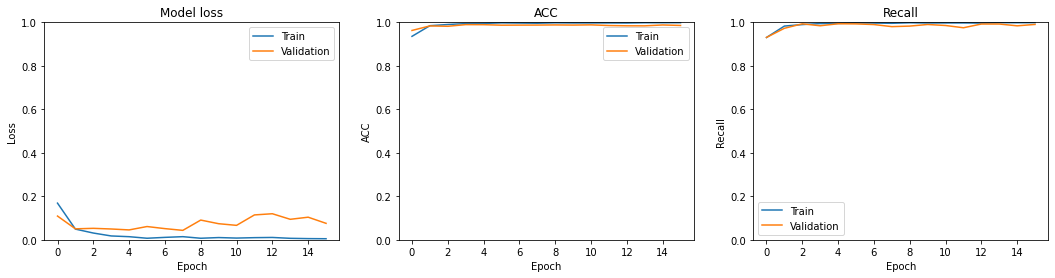

In [52]:
plot_loss(history, title=None)

In [53]:
results = text_model.evaluate(X_text_test_pad, y_test)

print('-'*80)
print(f"test score (ACC): {results[1]:.3f}")
print('-'*80)

419/419 [==============================] - 2s 4ms/step - loss: 0.0367 - accuracy: 0.9879 - precision: 0.9938 - recall: 0.9829
--------------------------------------------------------------------------------
test score (ACC): 0.988
--------------------------------------------------------------------------------


In [54]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def get_metrics(y_true, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

--------------------------------------------------------------------------------
acc: 98.79%
recall: 98.29%
precision: 99.38%
f1: 98.83%
--------------------------------------------------------------------------------


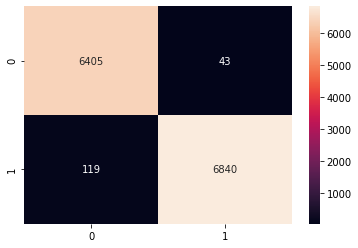

In [55]:
get_metrics(y_test, X_text_test_pad, text_model)

## Training on `title` data

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

title_model = init_model(**hparams)

history = title_model.fit(X_title_train_pad, 
                  y_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=15, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/15
196/196 [==============================] - 3s 12ms/step - loss: 0.2430 - accuracy: 0.9325 - precision: 0.9407 - recall: 0.9303 - val_loss: 0.1914 - val_accuracy: 0.9249 - val_precision: 0.9287 - val_recall: 0.9270
Epoch 2/15
196/196 [==============================] - 2s 10ms/step - loss: 0.1437 - accuracy: 0.9450 - precision: 0.9533 - recall: 0.9424 - val_loss: 0.1819 - val_accuracy: 0.9311 - val_precision: 0.9673 - val_recall: 0.8982
Epoch 3/15
196/196 [==============================] - 2s 10ms/step - loss: 0.1017 - accuracy: 0.9623 - precision: 0.9684 - recall: 0.9603 - val_loss: 0.1727 - val_accuracy: 0.9327 - val_precision: 0.9246 - val_recall: 0.9482
Epoch 4/15
196/196 [==============================] - 2s 10ms/step - loss: 0.0665 - accuracy: 0.9758 - precision: 0.9806 - recall: 0.9736 - val_loss: 0.2538 - val_accuracy: 0.9231 - val_precision: 0.8960 - val_recall: 0.9644
Epoch 5/15
196/196 [==============================] - 2s 10ms/step - loss: 0.0482 - accuracy: 0.9821

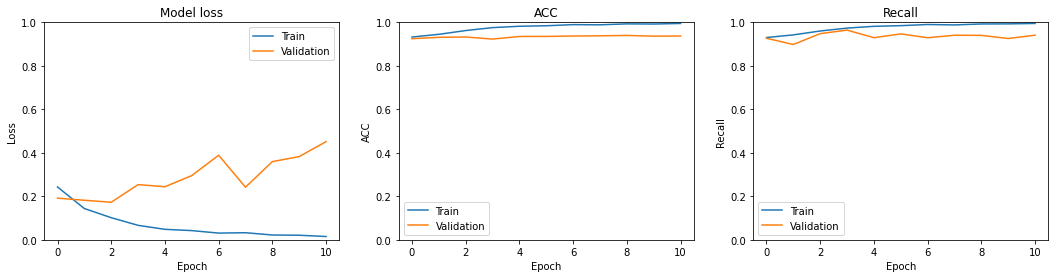

In [36]:
plot_loss(history, title=None)

In [37]:
results = title_model.evaluate(X_title_test_pad, y_test)

print('-'*80)
print(f"test score (ACC): {results[1]:.3f}")
print('-'*80)

419/419 [==============================] - 2s 4ms/step - loss: 0.1590 - accuracy: 0.9409 - precision: 0.9320 - recall: 0.9559
--------------------------------------------------------------------------------
test score (ACC): 0.941
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
acc: 94.09%
recall: 95.59%
precision: 93.20%
f1: 94.38%
--------------------------------------------------------------------------------


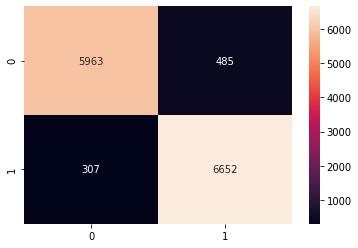

In [38]:
get_metrics(y_test, X_title_test_pad, title_model)